# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [134]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [135]:
pip install -U imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [136]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

#XGB
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, average_precision_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix,classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [137]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [139]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [140]:
df["booking_origin"].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [141]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [142]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [143]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [144]:
df.head(300)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1,Internet,RoundTrip,40,31,5,5,AKLKUL,New Zealand,1,1,1,8.83,0
296,1,Internet,RoundTrip,95,83,6,3,AKLKUL,New Zealand,0,0,0,8.83,1
297,1,Internet,RoundTrip,135,24,4,5,AKLKUL,New Zealand,0,0,0,8.83,0
298,1,Mobile,RoundTrip,15,90,13,5,AKLKUL,Germany,1,0,1,8.83,0


In [145]:
features = [x for x in df.columns]
print(len(features))

14


(0.0, 1.0, 0.0, 1.0)

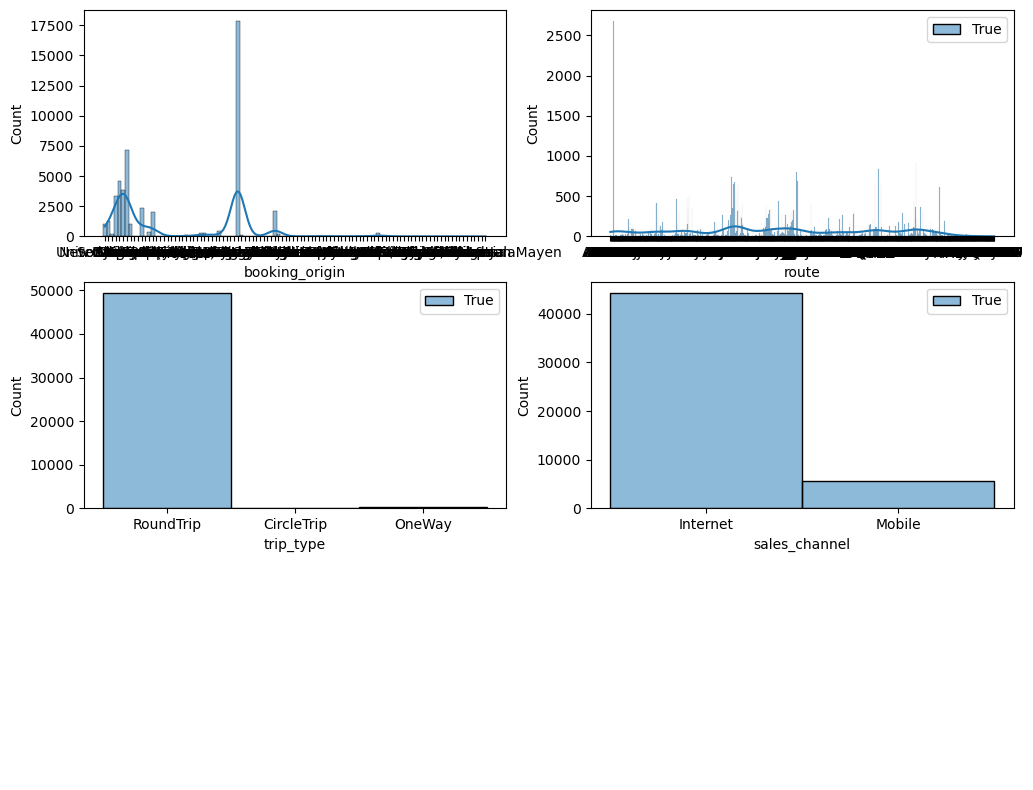

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,10))
sns.histplot(data = df, x ="booking_origin",kde = True,ax=axs[0][0])
sns.histplot(data = df, x ="route",kde = True,ax=axs[0][1], hue = True)
sns.histplot(data = df, x ="trip_type",kde = False,ax=axs[1][0],  hue = True)
sns.histplot(data = df, x ="sales_channel",kde = False,ax=axs[1][1],  hue = True)
# sns.histplot(data = df, x ="avg_sent_len",kde = True,ax=axs[2][0], )
axs[2][1].axis('off')
axs[2][0].axis('off')

## Check information (booking_origin, route, sales_channel, trip_type)

In [147]:
df.groupby("booking_origin").size().sort_values(ascending=False)

booking_origin
Australia         17872
Malaysia           7174
South Korea        4559
Japan              3885
China              3387
                  ...  
Seychelles            1
Norfolk Island        1
Pakistan              1
Panama                1
Nicaragua             1
Length: 104, dtype: int64

In [148]:
df.groupby("route").size()

route
AKLDEL    20
AKLHGH     1
AKLHND     2
AKLICN    70
AKLKIX     8
          ..
TRZWUH    13
TRZXIY     6
TWUWUH     2
TWUXIY     7
URTXIY     1
Length: 799, dtype: int64

In [149]:
df.groupby("sales_channel").size()

sales_channel
Internet    44382
Mobile       5618
dtype: int64

trip_type
CircleTrip      116
OneWay          387
RoundTrip     49497
dtype: int64

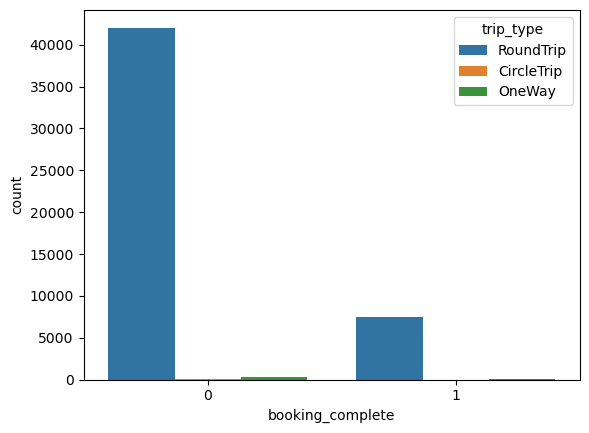

In [150]:
sns.countplot(data=df, x="booking_complete", hue="trip_type")
df.groupby("trip_type").size()

In [151]:
df.groupby("booking_complete").size()

booking_complete
0    42522
1     7478
dtype: int64

Delete "(not set)" values

In [152]:
df.drop(df.loc[df["booking_origin"] == "(not set)"].index, inplace=True)
result = df.loc[df["booking_origin"] == "(not set)"]
print(result)

Empty DataFrame
Columns: [num_passengers, sales_channel, trip_type, purchase_lead, length_of_stay, flight_hour, flight_day, route, booking_origin, wants_extra_baggage, wants_preferred_seat, wants_in_flight_meals, flight_duration, booking_complete]
Index: []


## Group Booking origin destination


In [153]:
df.groupby("booking_origin").size().sort_values(ascending = False)

booking_origin
Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
               ...  
Gibraltar          1
Ghana              1
Estonia            1
Seychelles         1
Afghanistan        1
Length: 103, dtype: int64

In [154]:
print(df['booking_origin'].unique())

['New Zealand' 'India' 'United Kingdom' 'China' 'South Korea' 'Japan'
 'Malaysia' 'Singapore' 'Switzerland' 'Germany' 'Indonesia'
 'Czech Republic' 'Vietnam' 'Thailand' 'Spain' 'Romania' 'Ireland' 'Italy'
 'Slovakia' 'United Arab Emirates' 'Tonga' 'Réunion' 'Saudi Arabia'
 'Netherlands' 'Qatar' 'Hong Kong' 'Philippines' 'Sri Lanka' 'France'
 'Croatia' 'United States' 'Laos' 'Hungary' 'Portugal' 'Cyprus'
 'Australia' 'Cambodia' 'Poland' 'Belgium' 'Oman' 'Bangladesh'
 'Kazakhstan' 'Brazil' 'Turkey' 'Kenya' 'Taiwan' 'Brunei' 'Chile'
 'Bulgaria' 'Ukraine' 'Denmark' 'Colombia' 'Iran' 'Bahrain'
 'Solomon Islands' 'Slovenia' 'Mauritius' 'Nepal' 'Russia' 'Kuwait'
 'Mexico' 'Sweden' 'Austria' 'Lebanon' 'Jordan' 'Greece' 'Mongolia'
 'Canada' 'Tanzania' 'Peru' 'Timor-Leste' 'Argentina' 'New Caledonia'
 'Macau' 'Myanmar (Burma)' 'Norway' 'Panama' 'Bhutan' 'Norfolk Island'
 'Finland' 'Nicaragua' 'Maldives' 'Egypt' 'Israel' 'Tunisia'
 'South Africa' 'Papua New Guinea' 'Paraguay' 'Estonia' 'Seychelle

In [155]:
region_dict = {'East Asia': ['China', 'South Korea', 'Japan', 'Hong Kong', 'Taiwan', 'Macau', 'Mongolia'],
               'Southeast Asia': ['Indonesia', 'Vietnam', 'Thailand', 'Malaysia', 'Singapore', 'Philippines', 'Cambodia', 'Brunei','Timor-Leste','Myanmar (Burma)','Laos'],
               'South Asia': ['India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Bhutan', 'Maldives','United Arab Emirates','Oman', 'Bangladesh','Bahrain'],
               'Central Asia': ['Kazakhstan','Iran','Kuwait','Jordan','Afghanistan'],
               'Western Asia' : ['Lebanon','Israel','Iraq','Saudi Arabia','Qatar'],
               'Northern Europe': ['United Kingdom', 'Ireland', 'Norway','Denmark','Sweden','Austria','Finland','Gibraltar','Svalbard & Jan Mayen'],
               'Western Europe': ['Switzerland', 'Germany', 'Netherlands', 'France', 'Belgium', 'Luxembourg','Slovenia','Malta'],
               'Southern Europe': ['Spain', 'Italy', 'Portugal', 'Cyprus', 'Greece', 'Malta'],
               'Eastern Europe': ['Czech Republic', 'Romania', 'Slovakia', 'Hungary', 'Poland', 'Bulgaria', 'Ukraine', 'Russia', 'Belarus', 'Estonia','Czechia','Turkey','Croatia'],
               'Northern Africa': ['Egypt', 'Tunisia', 'Algeria'],
               'Eastern Africa': ['Kenya', 'Tanzania','Réunion','Mauritius','Seychelles'],
               'Western Africa': ['Ghana'],
               'Southern Africa': ['South Africa'],
               'Oceania':['Australia','New Zealand','Tonga','Solomon Islands','New Caledonia','Norfolk Island','Papua New Guinea','Guam','Vanuatu'],
               'South America':['Brazil','Chile','Colombia','Mexico','Peru','Argentina','Paraguay','Guatemala'],
               'North America':['Canada','Panama','Nicaragua','United States']}


In [156]:
region_map = {}

for region, countries in region_dict.items():
    for country in countries:
        region_map[country] = region

df['region'] = df['booking_origin'].map(region_map)

In [157]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,region
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,Oceania
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,Oceania
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,South Asia
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,Oceania
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,South Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0,Oceania
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0,Oceania
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0,Oceania
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0,Oceania


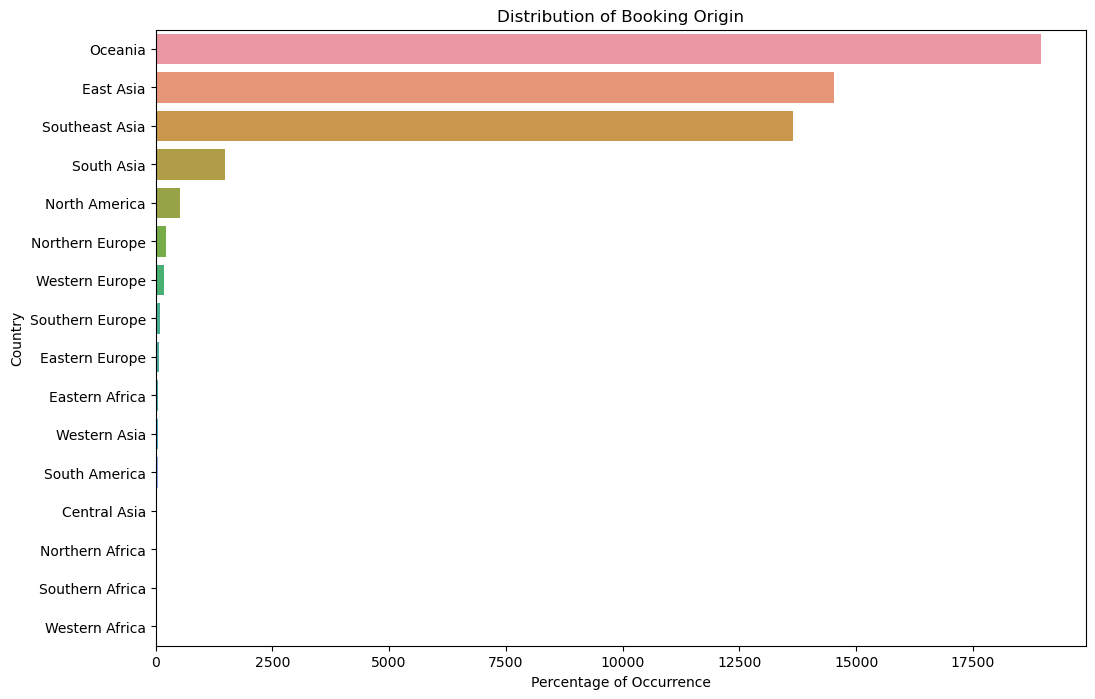

C:\Users\Dell\AppData\Local\Temp\ipykernel_20612\2112681977.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(region_size.index, rotation=90)


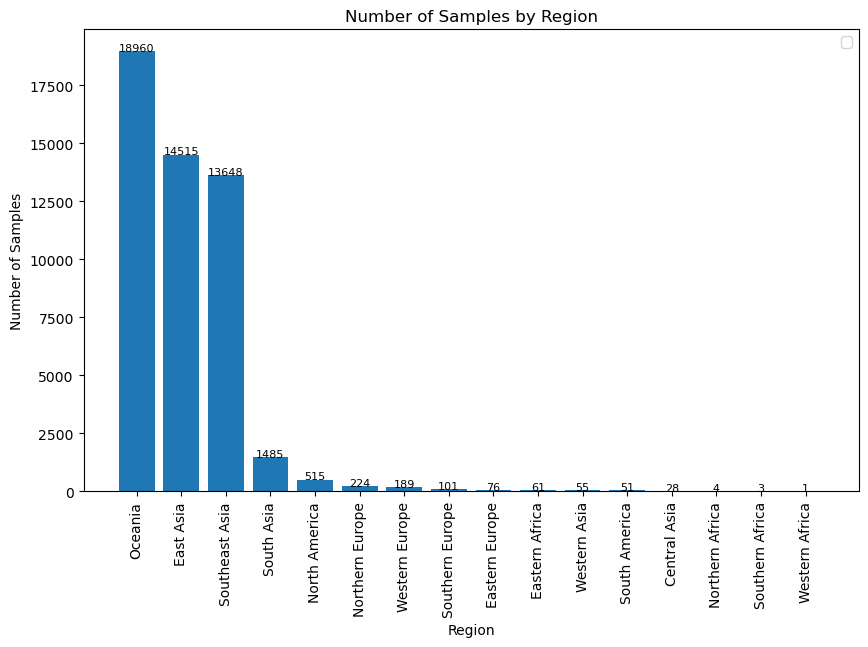

In [158]:
country_pct = df['region'].value_counts(normalize=True) * 100

# Create countplot
plt.figure(figsize=(12,8))
sns.countplot(data=df, y='region', order=country_pct.index)
plt.xlabel('Percentage of Occurrence')
plt.ylabel('Country')
plt.title('Distribution of Booking Origin')
plt.show()

df.groupby("region").size().sort_values(ascending = False)

# Group data by region and calculate size
region_size = df.groupby("region").size().sort_values(ascending=False)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(region_size.index, region_size.values)

# Set plot title and axis labels
ax.set_title("Number of Samples by Region")
ax.set_xlabel("Region")
ax.set_ylabel("Number of Samples")
ax.set_xticklabels(region_size.index, rotation=90)

# Add text labels to the top of each bar
for i, v in enumerate(region_size.values):
    ax.text(i, v, str(v), ha='center', fontsize=8, fontweight='normal')

# Create legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

# Show plot
plt.show()

## Check Null Values 

In [159]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
region                   0
dtype: int64

In [160]:
# null_age = df["region"].isnull()
# df_null_age = df[null_age]
# print(df_null_age)
null_region_df = df.loc[df['region'].isnull()]
null_region_df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,region


## Preprocessing Data and Trainning model XGBoost

In [161]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,region
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,Oceania
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,Oceania
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,South Asia
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,Oceania
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,South Asia


In [162]:
# predictor = ['num_passengers','purchase_lead','length_of_stay','flight_hour','flight_day','wants_extra_baggage','wants_preferred_seat', 'wants_in_flight_meals','flight_duration']
outcomes = "booking_complete"
predictor = [x for x in df.columns if x not in ['booking_origin','route','booking_complete']] ## Removing our target variable

### One-hot encoding using Pandas
First we will remove the binary variables, because one-hot encoding them would do nothing to them. To achieve this we will just count how many different values there are in each categorical variable and consider only the variables with 3 or more values.

As a reminder, one-hot encoding aims to transform a categorical variable with `n` outputs into `n` binary variables.

Pandas has a built-in method to one-hot encode variables, it is the function `pd.get_dummies`. There are several arguments to this function, but here we will use only a few. They are:

 - data: DataFrame to be used
 - prefix: A list with prefixes, so we know which value we are dealing with
 - columns: the list of columns that will be one-hot encoded. 'prefix' and 'columns' must have the same length.

In [163]:
# cat_variables = ['sales_channel',
# 'trip_type',
# # 'route',
# 'booking_origin',
# ]
# df = pd.get_dummies(data = df,
#                     prefix = cat_variables,
#                     columns = cat_variables)

X = pd.get_dummies(df[predictor], prefix='', prefix_sep='')
y = df[outcomes]

#RandomUnderSampler là một class trong thư viện imbalanced-learn được sử dụng để giảm thiểu sự mất cân bằng trong tập dữ liệu. Trong trường hợp này, rus được sử dụng để giảm thiểu sự mất cân bằng giữa các lớp trong tập dữ liệu bằng cách loại bỏ ngẫu nhiên một số mẫu từ lớp có số lượng lớn hơn. Điều này giúp giảm thiểu sai sót do mất cân bằng trong quá trình huấn luyện mô hình. Tham số random_state=777 được sử dụng để đảm bảo kết quả có thể tái lặp được.

In [164]:
rus = RandomUnderSampler(random_state=777)
X_res, y_res = rus.fit_resample(X,y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 7464, 1: 7464})


In [165]:
df_X_res = pd.DataFrame(X_res)
df_y_res = pd.DataFrame(y_res)
df_resample = pd.concat([df_X_res, df_y_res], axis=1)
df_resample.head()
print(df_resample.columns)

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'Internet', 'Mobile',
       'CircleTrip', 'OneWay', 'RoundTrip', 'Central Asia', 'East Asia',
       'Eastern Africa', 'Eastern Europe', 'North America', 'Northern Africa',
       'Northern Europe', 'Oceania', 'South America', 'South Asia',
       'Southeast Asia', 'Southern Africa', 'Southern Europe',
       'Western Africa', 'Western Asia', 'Western Europe', 'booking_complete'],
      dtype='object')


In [166]:
outcomes = "booking_complete"
predictor =  [x for x in df_resample.columns] ## Removing our target variable
X = df_resample[predictor]
y = df_resample[outcomes]

In [167]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 1)
train_dm = xgb.DMatrix(data=x_train, label=y_train)
valid_dm = xgb.DMatrix(data=x_valid, label=y_valid)

params ={ 'booster':'gbtree',
         'binary':'logistic',   
         'eval_metric': 'auc', #'rmse'
         'max_depth': 5,
         'min_child_weight':20, 
         'gamma':0, 
         'subsample':0.8,
         'colsample_bytree':0.8,
         'eta':0.01,  
         'random_state':7,
         'silent':0 
        }

evallist = [(train_dm,'train'), (valid_dm,'eval')]
# evals_result = {}

# xgb_model = xgb.train(params, train_dm, num_boost_round=100, evals=evallist, early_stopping_rounds=50, evals_result=evals_result)
xgb_model = xgb.train(params, train_dm, num_boost_round=100)

[18:56:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "binary", "silent" } are not used.



In [168]:
x_test = df_resample[df_resample['booking_complete']==1][predictor] # # lấy ra DataFrame con chỉ bao gồm các khách hàng đã hoàn thành đơn đặt hàng và các cột trong predictor
test_dm = xgb.DMatrix(data = x_test)
y_pred = xgb_model.predict(test_dm)
np.count_nonzero(y_pred > 0.5)

7464

In [169]:
x_test = df_resample[df_resample['booking_complete']==0][predictor]
test_dm = xgb.DMatrix(data = x_test)

y_pred = xgb_model.predict(test_dm)
np.count_nonzero(y_pred < 0.5)

7464

In [170]:
pred = xgb_model.predict(xgb.DMatrix(data = df_resample[predictor]))

In [171]:
# Confusion matrix
pred = xgb_model.predict(xgb.DMatrix(data = df_resample[predictor]))
pred_y = pred >= 0.5
true_y = y == 1
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat_XGB = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = churned', 'Y = continued'],
                       columns=['Y^ = churned', 'Y^ = continued'])
print(conf_mat_XGB)
conf_mat_XGB = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]])

               Y^ = churned  Y^ = continued
Y = churned            7464               0
Y = continued             0            7464


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

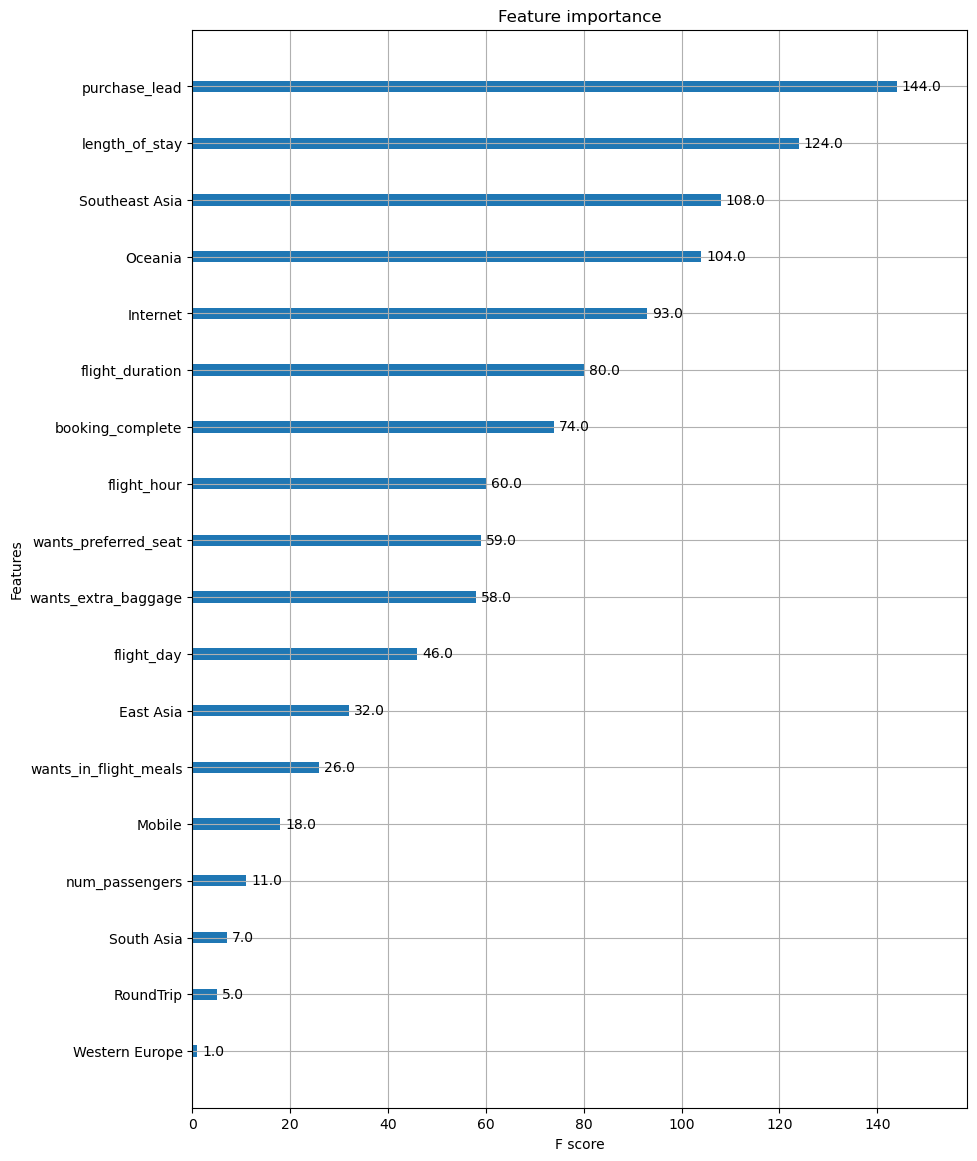

In [172]:
plot_features(xgb_model, (10,14))

## Random Forest test

In [173]:
# X_train, X_val, y_train, y_val = train_test_split(df[predictor], df[outcomes], train_size = 0.8, random_state = RANDOM_STATE)

# # We will keep the shuffle = True since our dataset has not any time dependency.

In [174]:
print(f'train samples: {len(X_train)} \\validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

NameError: name 'X_train' is not defined

In [ ]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

In [ ]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])